# Caption Generation for Multimodal Stance Classification

This notebook generates automatic captions for all images in the dataset using two models:
1. **BLIP-2** (Salesforce/blip2-opt-2.7b)
2. **GIT** (microsoft/git-large-coco)

The Idea: 
- Generate captions for train, dev, and test sets
- Compare caption styles between BLIP-2 and GIT

In [1]:
# Libraries
import os
import sys
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import warnings
from transformers import Blip2Processor,Blip2ForConditionalGeneration,AutoProcessor,AutoModelForCausalLM
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Paths
DATA_PATH = "../../../data/"
IMG_PATH = "../../../data/images"
OUTPUT_PATH = "../../../data/"  

In [3]:
# Model names
BLIP2_MODEL_NAME = "Salesforce/blip2-opt-2.7b"
GIT_MODEL_NAME = "microsoft/git-large-coco"

# Generation parameters
MAX_CAPTION_LENGTH = 50
NUM_BEAMS = 3
TEMPERATURE = 1.0
TOP_P = 0.9
REPETITION_PENALTY = 1.2

# Batch sizes
BATCH_SIZE_BLIP2 = 32  # BLIP-2 
BATCH_SIZE_GIT = 64    # GIT

print(f"BLIP-2 Model: {BLIP2_MODEL_NAME}")
print(f"GIT Model: {GIT_MODEL_NAME}")
print(f"Max caption length: {MAX_CAPTION_LENGTH}")
print(f"Batch size BLIP-2: {BATCH_SIZE_BLIP2}")
print(f"Batch size GIT: {BATCH_SIZE_GIT}")

BLIP-2 Model: Salesforce/blip2-opt-2.7b
GIT Model: microsoft/git-large-coco
Max caption length: 50
Batch size BLIP-2: 32
Batch size GIT: 64


In [4]:
# Load datasets
df_train = pd.read_csv(os.path.join(DATA_PATH, "train_augmented.csv"))
df_dev = pd.read_csv(os.path.join(DATA_PATH, "dev.csv"))
df_test = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

df_train.head()

tweet_id                tweet_url  \
0      1148501065308004357  https://t.co/VQP1FHaWAg   
1      1103872992537276417  https://t.co/zsyXYSeBkp   
2  1151528583623585794_aug  https://t.co/qSWvDX5MnM   
3      1100166844026109953  https://t.co/hxH8tFIHUu   
4      1021830413550067713  https://t.co/5whvEEtoQR   

                                          tweet_text   stance persuasiveness  \
0  Let's McGyver some Sanity in America!\n\nYou a...  support             no   
1  A child deserves a chance at life. A child des...   oppose             no   
2  Dear prolifers: girls as young as 10, 11, 12 a...  support             no   
3  The many States will attempt to amend their co...  support             no   
4  Every #abortion is wrong, no matter what metho...   oppose            yes   

   split  label  persuasiveness_label  
0  train      1                     0  
1  train      0                     0  
2  train      1                     0  
3  train      1                     0  
4  train      0                     1

In [5]:
def load_image_safe(img_path):
    try:
        image = Image.open(img_path).convert('RGB')
        return image
    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        return None


def batch_images(df, img_path, batch_size):
    """
    Generator that yields batches of images.
    """
    images = []
    indices = []
    
    for idx, row in df.iterrows():
        
        
        img_file = os.path.join(img_path, str(row['tweet_id']) + ".jpg")
        img = load_image_safe(img_file)
        
        if img is not None:
            images.append(img)
            indices.append(idx)
        else:
            # If image fails, add placeholder caption
            indices.append(idx)
            images.append(None)
        
        if len(images) == batch_size:
            yield images, indices
            images = []
            indices = []
    
    # Yield remaining
    if images:
        yield images, indices

## BLIP-2 Caption Generation

In [6]:
# Load BLIP-2 model and processor
print("Loading BLIP-2 model...")
blip2_processor = Blip2Processor.from_pretrained(BLIP2_MODEL_NAME)
blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    BLIP2_MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto")
blip2_model.eval()
print(f" BLIP-2 model loaded on {DEVICE}")

Loading BLIP-2 model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 BLIP-2 model loaded on cuda


In [7]:
def generate_captions_blip2(df, img_path, batch_size=32):
    """
    Generate captions using BLIP-2 for all images in dataframe.
    """
    captions = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for images, indices in tqdm(batch_images(df, img_path, batch_size), 
                                    total=total_batches,
                                    desc="BLIP-2 Captioning"):
            # Filter out None images
            valid_images = [img for img in images if img is not None]
            
            if not valid_images:
                captions.extend(["[Image load failed]"] * len(images))
                continue
            
            # Process images
            inputs = blip2_processor(images=valid_images, return_tensors="pt").to(DEVICE, torch.float16)
            
            # Generate captions
            generated_ids = blip2_model.generate(
                **inputs,
                max_length=MAX_CAPTION_LENGTH,
                num_beams=NUM_BEAMS,
                temperature=TEMPERATURE,
                top_p=TOP_P,
                repetition_penalty=REPETITION_PENALTY,
                early_stopping=True
            )
            
            # Decode captions
            batch_captions = blip2_processor.batch_decode(generated_ids, skip_special_tokens=True)
            
            # Handle None images
            caption_idx = 0
            for img in images:
                if img is None:
                    captions.append("[Image load failed]")
                else:
                    captions.append(batch_captions[caption_idx].strip())
                    caption_idx += 1
    
    return captions

In [8]:
# Generate BLIP-2 captions for all datasets
print("Generating captions for TRAIN set...")
train_captions_blip2 = generate_captions_blip2(df_train, IMG_PATH, BATCH_SIZE_BLIP2)
df_train['caption_blip2'] = train_captions_blip2

print("\nGenerating captions for DEV set...")
dev_captions_blip2 = generate_captions_blip2(df_dev, IMG_PATH, BATCH_SIZE_BLIP2)
df_dev['caption_blip2'] = dev_captions_blip2

print("\nGenerating captions for TEST set...")
test_captions_blip2 = generate_captions_blip2(df_test, IMG_PATH, BATCH_SIZE_BLIP2)
df_test['caption_blip2'] = test_captions_blip2

print("\nBLIP-2 caption generation completed!")

Generating captions for TRAIN set...


BLIP-2 Captioning:   0%|          | 0/69 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error loading ../../../data/images/1163936804006977536.jpg: cannot identify image file '../../../data/images/1163936804006977536.jpg'
Error loading ../../../data/images/1290280312962940928.jpg: cannot identify image file '../../../data/images/1290280312962940928.jpg'
Error loading ../../../data/images/1200177857869336576.jpg: cannot identify image file '../../../data/images/1200177857869336576.jpg'
Error loading ../../../data/images/1370338056415289348.jpg: cannot identify image file '../../../data/images/1370338056415289348.jpg'
Error loading ../../../data/images/1324601823555104768.jpg: cannot identify image file '../../../data/images/1324601823555104768.jpg'
Error loading ../../../data/images/1354941521422905347.jpg: cannot identify image file '../../../data/images/1354941521422905347.jpg'
Error loading ../../../data/images/1366231979495153664.jpg: cannot identify image file '../../../data/images/1366231979495153664.jpg'
Error loading ../../../data/images/1375886605555097603.jpg: ca

BLIP-2 Captioning:   0%|          | 0/7 [00:00<?, ?it/s]

Error loading ../../../data/images/1349706761033420801.jpg: cannot identify image file '../../../data/images/1349706761033420801.jpg'
Error loading ../../../data/images/1347578011751763968.jpg: cannot identify image file '../../../data/images/1347578011751763968.jpg'
Error loading ../../../data/images/1374785380164190214.jpg: cannot identify image file '../../../data/images/1374785380164190214.jpg'

Generating captions for TEST set...


BLIP-2 Captioning:   0%|          | 0/10 [00:00<?, ?it/s]


BLIP-2 caption generation completed!


In [9]:
# Analyze BLIP-2 captions
all_captions = train_captions_blip2 + dev_captions_blip2 + test_captions_blip2
lengths = [len(cap.split()) for cap in all_captions if cap]
stats = {'total': len(all_captions),
        'valid': len([c for c in all_captions if c]),
        'mean_length': np.mean(lengths) if lengths else 0}

print(f"Total Images: {len(df_train)+len(df_dev)+len(df_test)}")
print(f"Total captions: {stats['total']}")
print(f"Valid captions: {stats['valid']}")
print(f"Mean length (words): {stats['mean_length']:.2f}")

Total Images: 2690
Total captions: 2690
Valid captions: 2690
Mean length (words): 9.32


In [10]:
# Free memory
del blip2_model, blip2_processor
torch.cuda.empty_cache()

## GIT Caption Generation

In [11]:
# Load GIT model and processor
print("Loading GIT model...")
git_processor = AutoProcessor.from_pretrained(GIT_MODEL_NAME)
git_model = AutoModelForCausalLM.from_pretrained(
    GIT_MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
git_model.eval()
print(f"GIT model loaded on {DEVICE}")

Loading GIT model...


`torch_dtype` is deprecated! Use `dtype` instead!


GIT model loaded on cuda


In [12]:
def generate_captions_git(df, img_path, batch_size=64):
    """
    Generate captions using GIT for all images in dataframe.
    """
    captions = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for images, indices in tqdm(batch_images(df, img_path, batch_size), 
                                    total=total_batches,
                                    desc="GIT Captioning"):
            # Filter out None images
            valid_images = [img for img in images if img is not None]
            
            if not valid_images:
                captions.extend(["[Image load failed]"] * len(images))
                continue
            
            # Process images
            inputs = git_processor(images=valid_images, return_tensors="pt").to(DEVICE, torch.float16)
            
            # Generate captions
            generated_ids = git_model.generate(
                pixel_values=inputs.pixel_values,
                max_length=MAX_CAPTION_LENGTH,
                num_beams=NUM_BEAMS,
                temperature=TEMPERATURE,
                top_p=TOP_P,
                repetition_penalty=REPETITION_PENALTY,
                early_stopping=True)
            
            # Decode captions
            batch_captions = git_processor.batch_decode(generated_ids, skip_special_tokens=True)
            
            # Handle None images
            caption_idx = 0
            for img in images:
                if img is None:
                    captions.append("[Image load failed]")
                else:
                    captions.append(batch_captions[caption_idx].strip())
                    caption_idx += 1
    
    return captions

In [13]:
# Generate GIT captions for all datasets
print("Generating captions for TRAIN set...")
train_captions_git = generate_captions_git(df_train, IMG_PATH, BATCH_SIZE_GIT)
df_train['caption_git'] = train_captions_git

print("\nGenerating captions for DEV set...")
dev_captions_git = generate_captions_git(df_dev, IMG_PATH, BATCH_SIZE_GIT)
df_dev['caption_git'] = dev_captions_git

print("\nGenerating captions for TEST set...")
test_captions_git = generate_captions_git(df_test, IMG_PATH, BATCH_SIZE_GIT)
df_test['caption_git'] = test_captions_git

print("\nGIT caption generation completed!")

Generating captions for TRAIN set...


GIT Captioning:   0%|          | 0/35 [00:00<?, ?it/s]

Error loading ../../../data/images/1163936804006977536.jpg: cannot identify image file '../../../data/images/1163936804006977536.jpg'
Error loading ../../../data/images/1290280312962940928.jpg: cannot identify image file '../../../data/images/1290280312962940928.jpg'
Error loading ../../../data/images/1200177857869336576.jpg: cannot identify image file '../../../data/images/1200177857869336576.jpg'
Error loading ../../../data/images/1370338056415289348.jpg: cannot identify image file '../../../data/images/1370338056415289348.jpg'
Error loading ../../../data/images/1324601823555104768.jpg: cannot identify image file '../../../data/images/1324601823555104768.jpg'
Error loading ../../../data/images/1354941521422905347.jpg: cannot identify image file '../../../data/images/1354941521422905347.jpg'
Error loading ../../../data/images/1366231979495153664.jpg: cannot identify image file '../../../data/images/1366231979495153664.jpg'
Error loading ../../../data/images/1375886605555097603.jpg: ca

GIT Captioning:   0%|          | 0/4 [00:00<?, ?it/s]

Error loading ../../../data/images/1349706761033420801.jpg: cannot identify image file '../../../data/images/1349706761033420801.jpg'
Error loading ../../../data/images/1347578011751763968.jpg: cannot identify image file '../../../data/images/1347578011751763968.jpg'
Error loading ../../../data/images/1374785380164190214.jpg: cannot identify image file '../../../data/images/1374785380164190214.jpg'

Generating captions for TEST set...


GIT Captioning:   0%|          | 0/5 [00:00<?, ?it/s]


GIT caption generation completed!


In [14]:
# Analyze GIT captions
all_captions_git = train_captions_git + dev_captions_git + test_captions_git
lengths = [len(cap.split()) for cap in all_captions_git if cap]
stats_git = {'total': len(all_captions_git),
        'valid': len([c for c in all_captions_git if c]),
        'mean_length': np.mean(lengths) if lengths else 0}

print(f"Total Images: {len(df_train)+len(df_dev)+len(df_test)}")
print(f"Total captions: {stats_git['total']}")
print(f"Valid captions: {stats_git['valid']}")
print(f"Mean length (words): {stats_git['mean_length']:.2f}")

Total Images: 2690
Total captions: 2690
Valid captions: 2690
Mean length (words): 12.36


In [15]:
# Free memory
del git_model, git_processor
torch.cuda.empty_cache()

## Some Examples



EXAMPLE 1


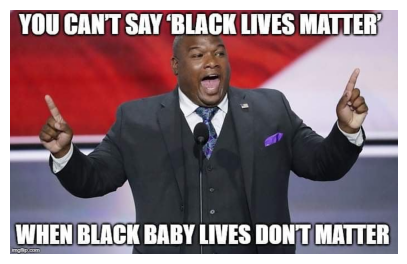

Stance: oppose
Original Text: Abortion is Evil...#prolife https://t.co/ZFpzUrJvGQ...

BLIP-2 Caption: you can't say black lives matter when black baby lives don't matter | image tagged
GIT Caption: a man in a suit is giving a speech.


EXAMPLE 2


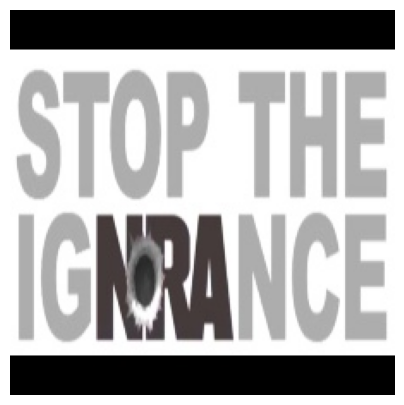

Stance: support
Original Text: Gundamentalists: "The 2nd Amendment is why 'Murica is free. Gun ownership provides a balance of power. Once that's gone, free speech is next. ✊" 
Ever...

BLIP-2 Caption: the words stop the nra on a white background
GIT Caption: a sign that says stop the ignorance.


EXAMPLE 3


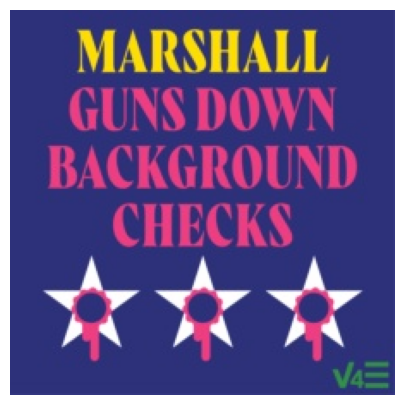

Stance: support
Original Text: Barbara Bollier supports common sense gun control, while Marshall wants to do nothing and let things get out of control. Safety should always be top p...

BLIP-2 Caption: marshall guns down background checks
GIT Caption: guns down background checks - the music of marshall guitars


EXAMPLE 4


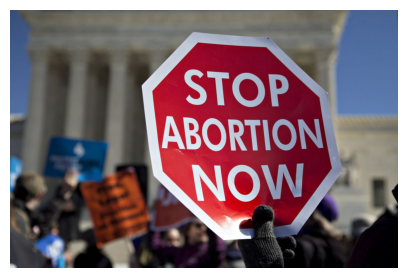

Stance: oppose
Original Text: Rep. Pebblin Warren, D-Tuskegee, says she has always been pro-life, but she fears an Alabama bill banning most abortions will ultimately cost taxpayer...

BLIP-2 Caption: stop abortion now signs are seen in front of the supreme court building in washington,
GIT Caption: a protester holds a stop sign during a rally.


EXAMPLE 5


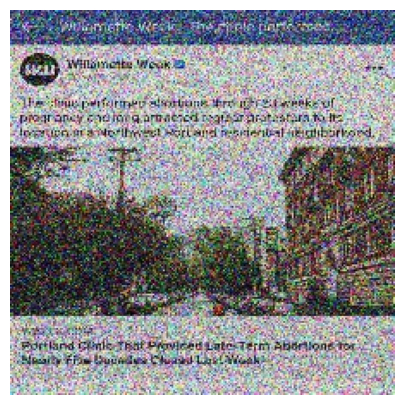

Stance: support
Original Text: The language @ wweek uses in it ' s newspaper headline borrows a false phrasing from anti - abortion group. 😡 " late term miscarriage " is medically f...

BLIP-2 Caption: a screenshot of the facebook page for the city of chicago
GIT Caption: a picture of a city street with buildings and trees.


EXAMPLE 6


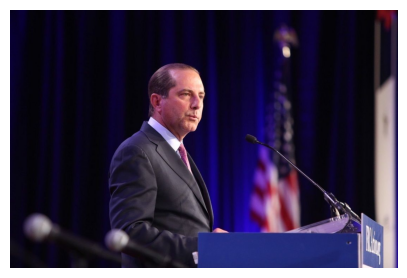

Stance: oppose
Original Text: CA’s abortion mandate devalues life and compels many Californians to support abortion against their will–which is a violation of federal law.The Trump...

BLIP-2 Caption: a man in a suit and tie speaking at a podium
GIT Caption: [ unused0 ] speaking at a podium.


EXAMPLE 7


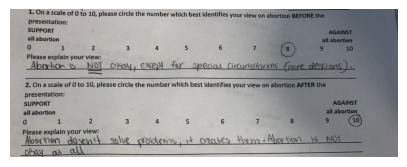

Stance: oppose
Original Text: Before: mostly pro-life 8/10. After 100% pro-life. “Abortion doesn’t solve problems, it creates them. Abortion is not okay at all.” https://t.co/4qtWD...

BLIP-2 Caption: a paper with writing on it that has a question
GIT Caption: write the number which best identifies your view on ab


EXAMPLE 8


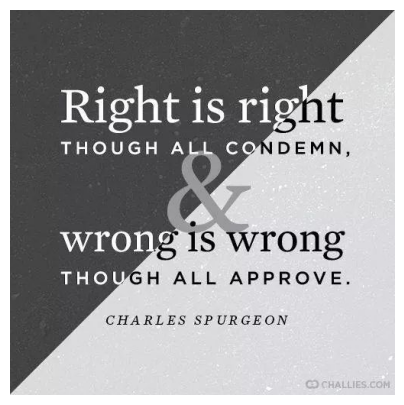

Stance: oppose
Original Text: I am SO SICK of hearing "reproductive freedom" Everyone is FREE to REPRODUCE!
It is ABORTION!! 
Libs needs to grow up and OWN IT!! 
Euphemisms won't m...

BLIP-2 Caption: right is right though all condemn wrong is wrong though all approve
GIT Caption: right is right, though all concern, and wrong is wrong. - [ unused0 ]


EXAMPLE 9


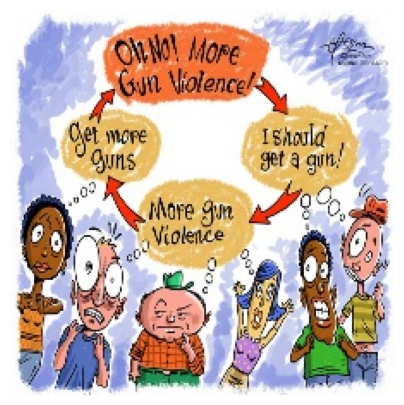

Stance: support
Original Text: This has been going on since I was a kid. Guns are too easy to acquire, c'mon already. #shootings #assaultweaponsban #GunControlNow #GunReformNow  #Gu...

BLIP-2 Caption: a cartoon drawing of a group of people talking about gun violence
GIT Caption: a cartoon of a group of people talking.


EXAMPLE 10


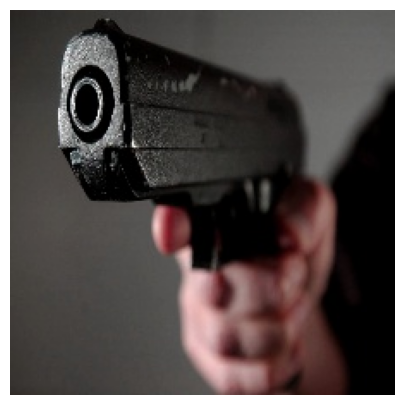

Stance: support
Original Text: Ghost guns are a new menace that takes advantage of the loophole to nearly every gun safety law. 

#RTClient @GiffordsCourage says watch this video to...

BLIP-2 Caption: a person is holding a gun in their hand
GIT Caption: a close up of a person holding a gun


EXAMPLE 11


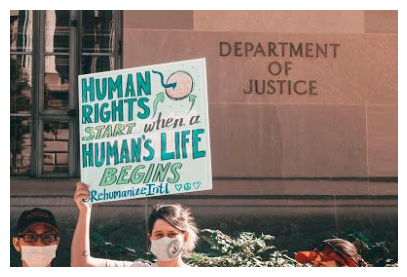

Stance: oppose
Original Text: If a fetus is not a human, then abortion restrictions stop women from having a basic, harmless medical procedure. 

If a fetus is a human, then each a...

BLIP-2 Caption: a group of people holding signs outside the department of justice building
GIT Caption: a woman holding a sign that says ` ` human rights start when a human ' s life begins ' '


EXAMPLE 12


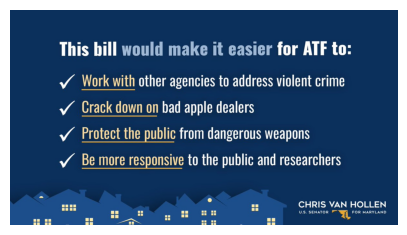

Stance: support
Original Text: At a time when the GOP is ramming through their NRA-backed SCOTUS nominee, it’s critical we adopt common-sense gun safety measures. I’m introducing th...

BLIP-2 Caption: this bill would make it easier to att
GIT Caption: a blue background with text that reads ` ` bill would make it easier for america. work with other agencies to address violent crimes.


EXAMPLE 13


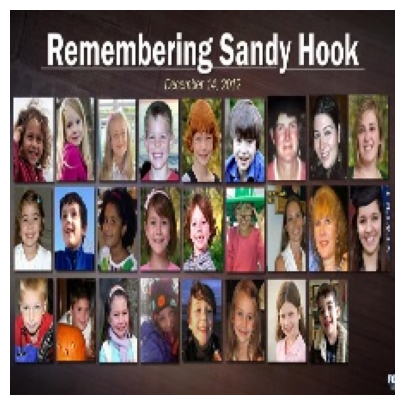

Stance: support
Original Text: Sad, Solemn Solar day of Remembrance here in the Little Nation of Connecticut river. Can we please do something astir Gun Control across the USA? ? Th...

BLIP-2 Caption: a poster with pictures of children who died in sandy hook
GIT Caption: a collage of pictures of many children.


EXAMPLE 14


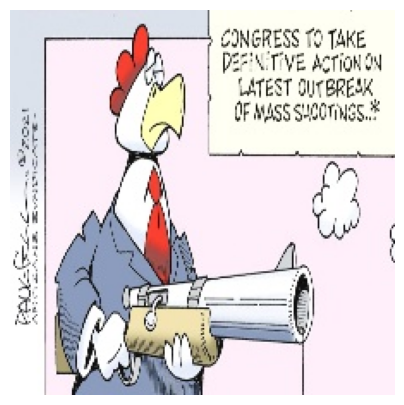

Stance: support
Original Text: For those chickens in Sexual intercourse too scared to fill action on gun safety device, even when over 80% support it, the usual # thoughtsandprayers...

BLIP-2 Caption: a political cartoon with a chicken holding a gun
GIT Caption: cartoon of a chicken holding a gun.


EXAMPLE 15


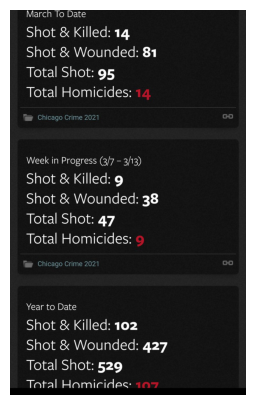

Stance: oppose
Original Text: Wondering what #GunControl laws will prevent this?

#thugs don't follow laws https://t.co/apvbSryKPS...

BLIP-2 Caption: chicago police crime map- screenshot
GIT Caption: a screenshot of a cell phone description automatically generated


EXAMPLE 16


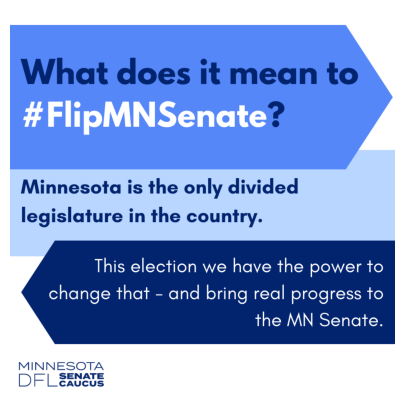

Stance: support
Original Text: This election, a lot is on the line. DFLers are ready to secure affordable and accessible health care, pass common sense gun safety laws, address clim...

BLIP-2 Caption: what does it mean to flip-mn?
GIT Caption: a graphic with the text that reads, ` ` state senate? ' '


EXAMPLE 17


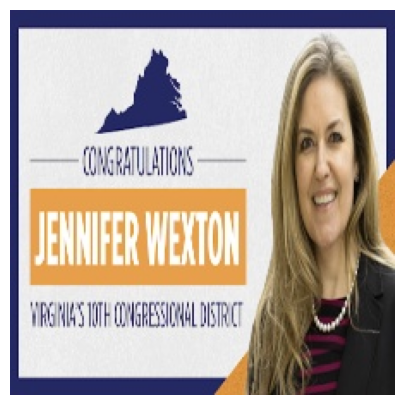

Stance: support
Original Text: Congratulations to @JenniferWexton on a big re-election win in #VA10.

She will fight for common-sense gun safety reforms, like universal background c...

BLIP-2 Caption: congratulations to jennifer wexton on her victory in virginia's 10th
GIT Caption: a woman with blonde hair and a striped shirt.


EXAMPLE 18


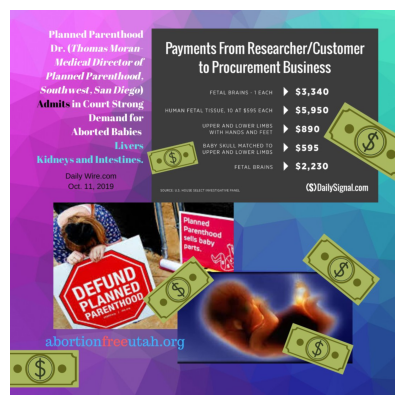

Stance: oppose
Original Text: The practice of murdering babies to harvest their organs is despicable and needs to be stopped!  #prolife #defundpp #ppsellsbabyparts https://t.co/B38...

BLIP-2 Caption: payments from researchers to procurement business
GIT Caption: contest entry # 3 for design a flyer for a charity event


EXAMPLE 19


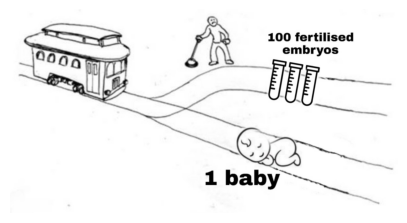

Stance: oppose
Original Text: A baby is going to be run over by a trolley.

You can save the baby by switching tracks.

In doing so you destroy 100 fertilised embryos.

What do you...

BLIP-2 Caption: a drawing of a trolley with a baby on it
GIT Caption: 100 feet of a baby


EXAMPLE 20


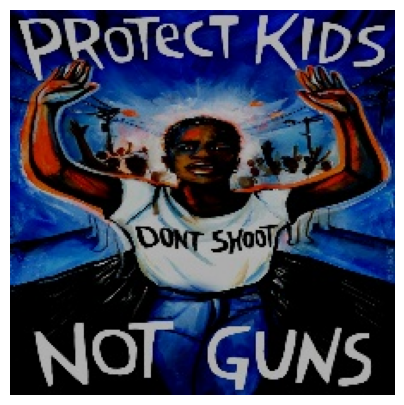

Stance: support
Original Text: This post made by @ micahbazant speaks deeply on the problem of gun control in our commonwealth. Still though it ' s meant for self defense, knowing t...

BLIP-2 Caption: protect kids don't shoot not guns
GIT Caption: a painting of a person holding up arms.


EXAMPLE 21


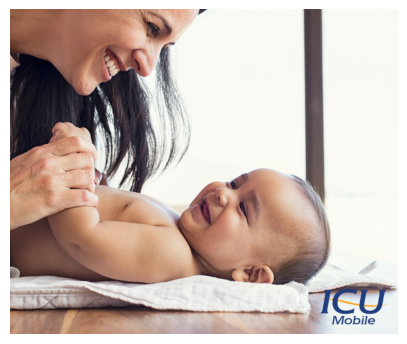

Stance: oppose
Original Text: We have seen over 9,000 women decide to parent so their babies can experience the best of life. #prolife #chooselife https://t.co/KZ3VlfK7Ok...

BLIP-2 Caption: a woman smiles while holding a baby
GIT Caption: a mother and her baby smiling at each other.


EXAMPLE 22


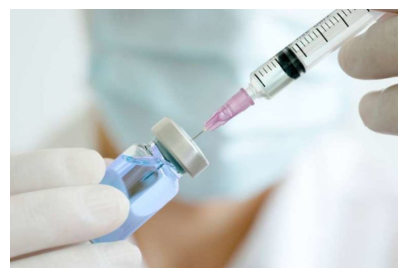

Stance: oppose
Original Text: Pro-life leaders call for a coronavirus vaccine that avoids unethical links to abortion. https://t.co/3EgXJDBJWC https://t.co/cNAzeff1nF...

BLIP-2 Caption: a person in a white lab coat is holding an injection
GIT Caption: a close - up of a syringe being inserted into a syringe


EXAMPLE 23


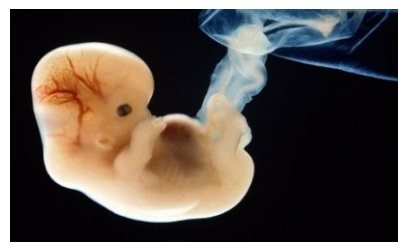

Stance: oppose
Original Text: Behold, a 6-week old, Human fetus. The Globalist Left calls this baby a Nuisance, for any mother seeking an abortion. 
In the 2nd photo, is what MAY b...

BLIP-2 Caption: a fetus in the womb with smoke coming out of it
GIT Caption: an image of a baby in the womb.


EXAMPLE 24


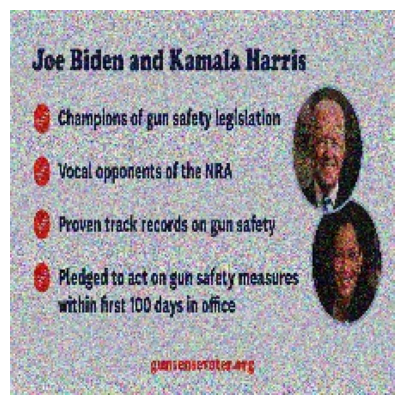

Stance: support
Original Text: Wondering why we keep saying that # BidenHarris2020 is the hard gun safety just the ticket in American history? Simple: they ’ re champions of common ...

BLIP-2 Caption: joe biden and kamala harris
GIT Caption: a picture of two men and two women.


EXAMPLE 25


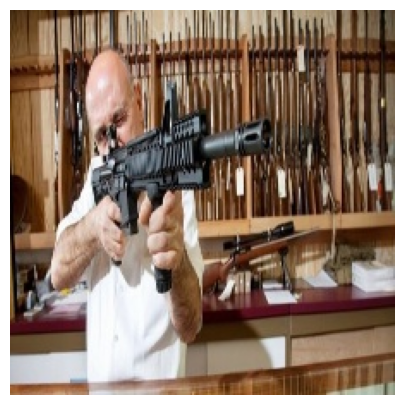

Stance: support
Original Text: Instead of leading, Trump constitute scaring masses of people into buying guns to ‘ protect ’ themselves. # care2 https: / / t. co / LRoYlzLnHl Arming...

BLIP-2 Caption: a man holding an automatic rifle in a gun shop
GIT Caption: a man holding a gun in a store.


EXAMPLE 26


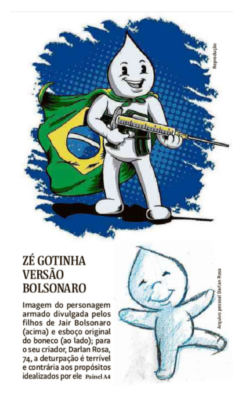

Stance: oppose
Original Text: How the Bolsonaro family perverted a cartoon character meant to promote vaccination, associating it with gun violence, a perversion its creator finds ...

BLIP-2 Caption: zgottina bolsonaro
GIT Caption: brazil ' s [ unused0 ] is a brazilian hero.


EXAMPLE 27


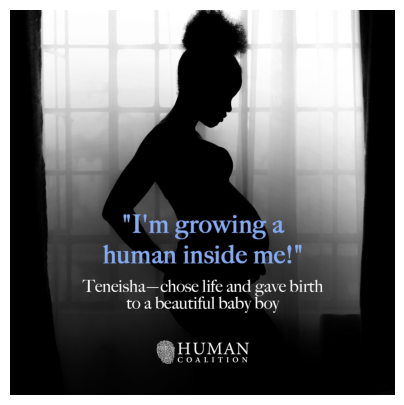

Stance: oppose
Original Text: We know unexpected pregnancy can be scary. But there is hope and help!

#ReachRescueRestore; #HumanCoalition; #Savethebabyhumans; #Preborn; #Rescuethe...

BLIP-2 Caption: i'm growing a human inside me
GIT Caption: ##0 ] - - [ unused0 ] : ` ` i ' m growing a human inside me! ' ' - - [ unused0 ] : ` ` i ' m growing a human inside


EXAMPLE 28


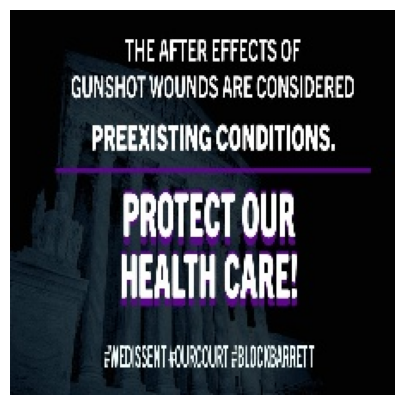

Stance: support
Original Text: Gun violence in America is a public health crisis. Every year, +110,000 people are shot. But Amy Coney Barrett could gut both our gun safety laws AND ...

BLIP-2 Caption: the after effects of gunshot wounds are considered
GIT Caption: a poster with the words ` ` the after effects of gunsight wounds are considered prenatal conditions. protect our health care! ' '


EXAMPLE 29


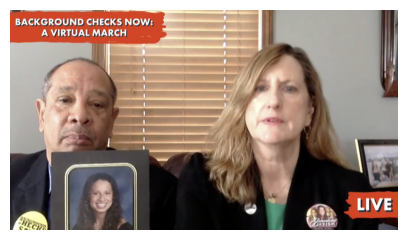

Stance: support
Original Text: “[Strong gun safety laws] can make the difference between life and death. Between justice and always wondering who killed someone you love. Between me...

BLIP-2 Caption: a man and woman are sitting in front of a picture
GIT Caption: [ unused0 ] and [ unused0 ] at a news conference.


EXAMPLE 30


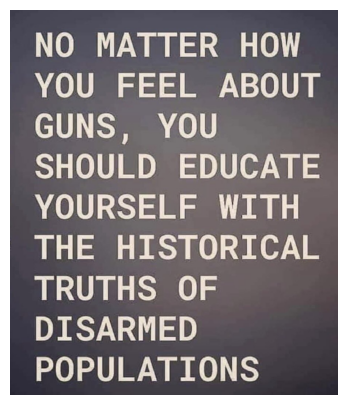

Stance: oppose
Original Text: There are nearly 400 million firearms in the US, controlled very well by over 150 million legal owners. We don’t need the government to control us. Th...

BLIP-2 Caption: no matter how you feel about guns, you should educate yourself with the historical truths of
GIT Caption: no matter how you feel about guns, you should educate yourself with the historical truths of disorientation.


In [20]:
#Examples Side by Side
samples = df_train.sample(n=30, random_state=42)

for idx, (_, row) in enumerate(samples.iterrows(), 1):
    print(f"\n\nEXAMPLE {idx}")

    # Load Image
    img_path = os.path.join(IMG_PATH, str(row['tweet_id']) + ".jpg")
    img = load_image_safe(img_path)
        

    # Show Image
    plt.figure(figsize=(5, 5))
    if img is not None:
        plt.imshow(img)
    else:
        plt.imshow(np.ones((224, 224, 3)))  # default
        plt.title("Image not found")

    plt.axis('off')
    plt.show()

    # Info
    print(f"Stance: {row['stance']}")
    print(f"Original Text: {row['tweet_text'][:150]}...")
    print(f"\nBLIP-2 Caption: {row['caption_blip2']}")
    print(f"GIT Caption: {row['caption_git']}")

## Save Captions

In [17]:
# Save augmented datasets
train_output_path = os.path.join(OUTPUT_PATH, "train_with_captions.csv")
dev_output_path = os.path.join(OUTPUT_PATH, "dev_with_captions.csv")
test_output_path = os.path.join(OUTPUT_PATH, "test_with_captions.csv")

df_train.to_csv(train_output_path, index=False)
df_dev.to_csv(dev_output_path, index=False)
df_test.to_csv(test_output_path, index=False)

print("Datasets saved")
print(f"Train: {train_output_path}")
print(f"Dev: {dev_output_path}")
print(f"Test: {test_output_path}")

Datasets saved
Train: ../../../data/train_with_captions.csv
Dev: ../../../data/dev_with_captions.csv
Test: ../../../data/test_with_captions.csv
